In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_excel('NutriScore_Dynamic_Dataset.xlsx', sheet_name='Sheet1')
df.head()

,Nom_Produit,Marque,Categorie,Energie_kJ,Sucres_g,Graisses_Sat_g,Sel_g,Proteines_g,Fibres_g,Fruits_Legumes_Pct,NutriScore_Score,NutriScore_Lettre,Points_N,Points_P,GreenScore_Lettre,GreenScore_Score
0,Concentré de tomates Aicha,Aicha,vegetables,132.0,2.43,0.0,0.270,1.24,0.811,0.0,1,B,1,0,C,59
1,Aicha Tomato Paste,Aicha,vegetables,496.0,9.00,0.0,0.500,4.60,3.000,0.0,3,C,4,1,C,46
2,Raw kimchi,Vadasz,vegetables,63.0,0.00,0.1,2.065,1.10,1.800,0.0,10,C,10,0,A,88
3,Beurre de cacahuètes,Maribel,vegetables,2860.0,3.90,12.0,0.030,30.40,9.200,0.0,14,D,19,5,D,34
4,Carottes rapees citron dnp 320g,Bonduelle,vegetables,301.0,4.50,0.3,0.710,1.00,3.000,86.0,-1,A,4,5,A,79


In [4]:
df['Nom_Produit'] = df['Nom_Produit'].str.replace(r'[^\w\s]', '', regex=True)
df.head()

,Nom_Produit,Marque,Categorie,Energie_kJ,Sucres_g,Graisses_Sat_g,Sel_g,Proteines_g,Fibres_g,Fruits_Legumes_Pct,NutriScore_Score,NutriScore_Lettre,Points_N,Points_P,GreenScore_Lettre,GreenScore_Score
0,Concentré de tomates Aicha,Aicha,vegetables,132.0,2.43,0.0,0.270,1.24,0.811,0.0,1,B,1,0,C,59
1,Aicha Tomato Paste,Aicha,vegetables,496.0,9.00,0.0,0.500,4.60,3.000,0.0,3,C,4,1,C,46
2,Raw kimchi,Vadasz,vegetables,63.0,0.00,0.1,2.065,1.10,1.800,0.0,10,C,10,0,A,88
3,Beurre de cacahuètes,Maribel,vegetables,2860.0,3.90,12.0,0.030,30.40,9.200,0.0,14,D,19,5,D,34
4,Carottes rapees citron dnp 320g,Bonduelle,vegetables,301.0,4.50,0.3,0.710,1.00,3.000,86.0,-1,A,4,5,A,79


In [5]:
df.to_csv('NutriScore_Dynamic_Dataset_Cleaned.csv', index=False)

In [6]:
def add_column_if_missing(df, colname, values):
    """Ajoute une colonne si elle n'existe pas déjà."""
    if colname not in df.columns:
        df[colname] = values
    else:
        print(f"⚠️ Colonne '{colname}' déjà existante → non modifiée.")
    return df


class ElectreTri:
    def __init__(self, criteria, directions, weights,
                 category_labels=None, lambdas=(0.6, 0.7),
                 preference_thresholds=None):
        """
        criteria: liste des noms de colonnes
        directions: dict crit -> 1 (plus c'est grand mieux) ou -1
        weights: dict crit -> poids
        category_labels: labels des catégories ELECTRE
        lambdas: valeurs de lambda testées
        preference_thresholds: dict crit -> seuil de préférence p
        """
        self.criteria = criteria
        self.directions = directions
        self.weights = self._normalize_weights(weights)
        self.category_labels = category_labels or ["E'", "D'", "C'", "B'", "A'"]
        self.lambdas = lambdas
        self.preference_thresholds = preference_thresholds or {
            c: 0.0 for c in criteria
        }
        self.profiles = None  # sera construit à partir du df

    @staticmethod
    def _normalize_weights(weights):
        total = sum(weights.values())
        return {k: v / total for k, v in weights.items()}

    def _partial_concordance(self, a_val, b_val, crit):
        """C_i(a,b) pour un critère donné."""
        direction = self.directions[crit]
        p = self.preference_thresholds.get(crit, 0.0)

        if direction == 1:
            return 1.0 if a_val + p >= b_val else 0.0
        else:
            return 1.0 if a_val - p <= b_val else 0.0

    def _concordance(self, a, b):
        """Indice de concordance global C(a,b)."""
        c_val = 0.0
        for crit in self.criteria:
            ci = self._partial_concordance(a[crit], b[crit], crit)
            c_val += self.weights[crit] * ci
        return c_val

    def _outranks(self, a, b, lambd):
        """Test a S b (a surclasse b)."""
        return self._concordance(a, b) >= lambd

    def _strictly_preferred(self, a, b, lambd):
        """a ≻ b si a S b et non (b S a)."""
        return self._outranks(a, b, lambd) and not self._outranks(b, a, lambd)

    def build_limiting_profiles(self, df, eps=1e-6):
        """
        Construit les profils pi1..pi6 à partir des quantiles de df.
        """
        profiles_index = [f"pi{k}" for k in range(1, 7)]
        profiles = pd.DataFrame(index=profiles_index, columns=self.criteria, dtype=float)

        for crit in self.criteria:
            col = df[crit].astype(float)
            q20, q40, q60, q80 = col.quantile([0.2, 0.4, 0.6, 0.8])
            cmin, cmax = col.min(), col.max()

            if self.directions[crit] == 1:
                profiles.loc["pi1", crit] = cmin - eps
                profiles.loc["pi2", crit] = q20
                profiles.loc["pi3", crit] = q40
                profiles.loc["pi4", crit] = q60
                profiles.loc["pi5", crit] = q80
                profiles.loc["pi6", crit] = cmax + eps
            else:
                profiles.loc["pi1", crit] = cmax + eps
                profiles.loc["pi2", crit] = q80
                profiles.loc["pi3", crit] = q60
                profiles.loc["pi4", crit] = q40
                profiles.loc["pi5", crit] = q20
                profiles.loc["pi6", crit] = cmin - eps

        self.profiles = profiles
        return profiles

    def _assign_pessimistic_row(self, row, lambd):
        """Affectation pessimiste d’une seule alternative."""
        assigned_cat = self.category_labels[0]  # pire catégorie par défaut
        for k in range(5, 0, -1):
            pi_k = self.profiles.loc[f"pi{k}"]
            if self._outranks(row, pi_k, lambd):
                assigned_cat = self.category_labels[k - 1]
                break
        return assigned_cat

    def _assign_optimistic_row(self, row, lambd):
        """Affectation optimiste d’une seule alternative."""
        assigned_cat = self.category_labels[-1]  # meilleure catégorie par défaut
        for k in range(2, 7):
            pi_k = self.profiles.loc[f"pi{k}"]
            if self._strictly_preferred(pi_k, row, lambd):
                assigned_cat = self.category_labels[k - 2]
                break
        return assigned_cat

    def assign_pessimistic(self, df, lambd):
        return df.apply(lambda row: self._assign_pessimistic_row(row, lambd), axis=1)

    def assign_optimistic(self, df, lambd):
        return df.apply(lambda row: self._assign_optimistic_row(row, lambd), axis=1)

    def apply_and_confusion(self, df, target_col="NutriScore_Lettre"):
        """
        1) Construit les profils
        2) Ajoute les colonnes ELECTRE (pess/opt pour chaque lambda)
        3) Calcule les matrices de confusion
        """
        # 1. Profils
        self.build_limiting_profiles(df)

        confusion_results = {}
        labels_true = ["A", "B", "C", "D", "E"]
        pred_cols = ["A'", "B'", "C'", "D'", "E'"]

        for lambd in self.lambdas:
            # Pessimiste
            colname_pess = f"ELECTRE_Pess_{lambd}"
            pess = self.assign_pessimistic(df, lambd)
            df = add_column_if_missing(df, colname_pess, pess)

            cm_pess = confusion_matrix(
                df[target_col],
                df[colname_pess],
                labels=labels_true
            )
            confusion_results[colname_pess] = pd.DataFrame(
                cm_pess,
                index=[f"NS_{l}" for l in labels_true],
                columns=pred_cols
            )

            # Optimiste
            colname_opt = f"ELECTRE_Opt_{lambd}"
            opt = self.assign_optimistic(df, lambd)
            df = add_column_if_missing(df, colname_opt, opt)

            cm_opt = confusion_matrix(
                df[target_col],
                df[colname_opt],
                labels=labels_true
            )
            confusion_results[colname_opt] = pd.DataFrame(
                cm_opt,
                index=[f"NS_{l}" for l in labels_true],
                columns=pred_cols
            )

        return df, confusion_results

    @staticmethod
    def plot_confusion_matrices(confusion_results):
        """
        Affiche les matrices de confusion sous forme de heatmaps matplotlib.
        confusion_results: dict nom -> DataFrame
        """
        n = len(confusion_results)
        cols = 2
        rows = int(np.ceil(n / cols))

        # constrained_layout gère automatiquement la place pour la colorbar
        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows),
                                constrained_layout=True)
        axes = np.array(axes).reshape(-1)

        im = None
        for ax, (name, cm_df) in zip(axes, confusion_results.items()):
            im = ax.imshow(cm_df.values, aspect="auto")
            ax.set_title(name)
            ax.set_xticks(range(cm_df.shape[1]))
            ax.set_xticklabels(cm_df.columns)
            ax.set_yticks(range(cm_df.shape[0]))
            ax.set_yticklabels(cm_df.index)
            ax.set_xlabel("Catégorie ELECTRE")
            ax.set_ylabel("NutriScore réel")

            # valeurs dans les cases
            for i in range(cm_df.shape[0]):
                for j in range(cm_df.shape[1]):
                    ax.text(j, i, int(cm_df.iat[i, j]),
                            ha="center", va="center")

        # supprimer les axes en trop s'il y en a
        for ax in axes[n:]:
            ax.remove()

        # colorbar commune à tous les axes, avec un peu d'espace (pad)
        fig.colorbar(im, ax=axes[:n], fraction=0.046, pad=0.04)

        plt.show()



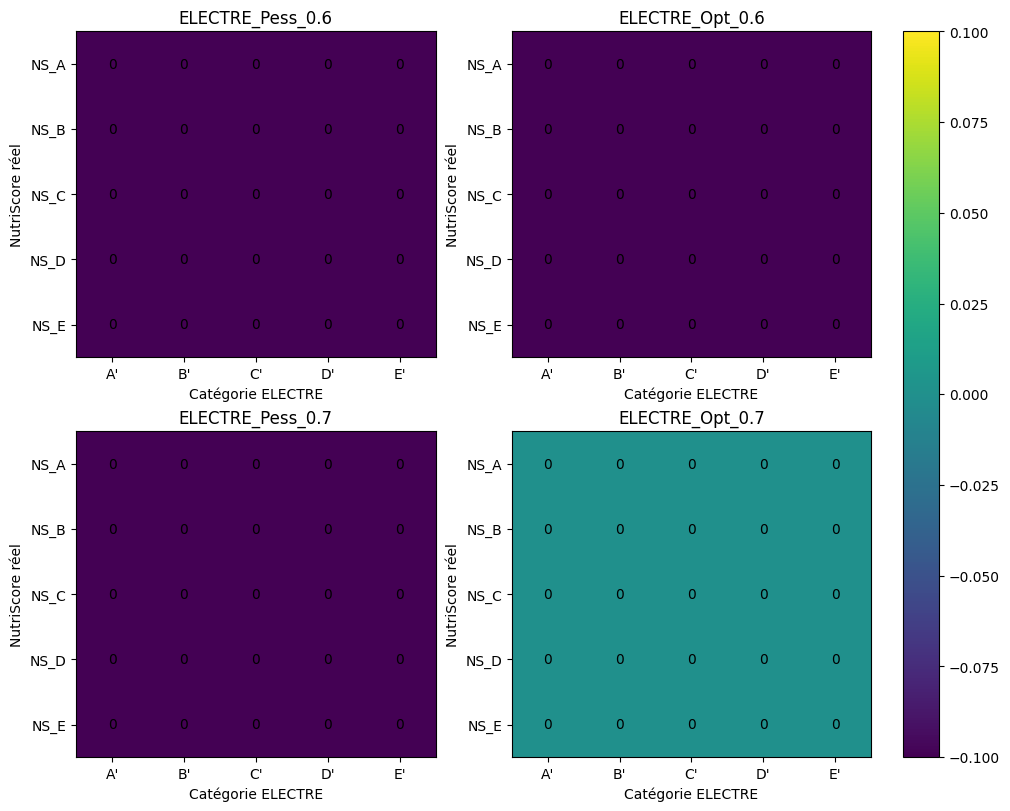

In [ ]:
criteria = [
    "Energie_kJ", "Sucres_g", "Graisses_Sat_g", "Sel_g",
    "Proteines_g", "Fibres_g", "Fruits_Legumes_Pct", "GreenScore_Score"
]

directions = {
    "Energie_kJ": -1,
    "Sucres_g": -1,
    "Graisses_Sat_g": -1,
    "Sel_g": -1,
    "Proteines_g": 1,
    "Fibres_g": 1,
    "Fruits_Legumes_Pct": 1,
    "GreenScore_Score": 1
}

weights = {c: 1 / len(criteria) for c in criteria}
category_labels = ["E", "D", "C", "B", "A"]

model = ElectreTri(
    criteria=criteria,
    directions=directions,
    weights=weights,
    category_labels=category_labels,
    lambdas=(0.6, 0.7)
)

df, confusions = model.apply_and_confusion(df, target_col="NutriScore_Lettre")

# Affichage graphique des matrices de confusion
ElectreTri.plot_confusion_matrices(confusions)


In [8]:
df.to_csv('NutriScore_Dynamic_Dataset_ELECTRE.csv', index=False)